In [16]:
import pandas as pd
import re
import datetime
import json
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing

In [246]:
filename='../raw/flores_dynabench_raw_data'
PROJECT_LABEL_REGEX_1 = (
    r'.*/ts(?P<timestamp>\d+)-(?P<modelname>.*)/flores_(?P<taskname>[a-z0-9]+)/.*-(?P<setname>[a-z0-9]+).jsonl.out'
)

In [247]:

with open(filename,'r') as file:
    next(file)
    data = []
    for line in file:
        mid,raw_output_s3_uri,pretty_perf, langs, perfs = line.split('\t')
        try:
            match = re.match(PROJECT_LABEL_REGEX_1,raw_output_s3_uri)
            timestamp = datetime.datetime.fromtimestamp(int(match.group('timestamp')))
            taskname=match.group('taskname')
            modelname=match.group('modelname')
            setname=match.group('setname')
            lgs = json.loads(langs)
            prfs = [ float('{:.2f}'.format(float(x))) for x in json.loads(perfs.replace(' %',''))]
            for lang_pair, perf in zip(lgs, prfs):
                src,trg = lang_pair.split("-")
                data.append((int(mid), modelname, timestamp, setname, taskname, src, trg, perf))  
        except e:
            print(e)
            print(raw_output_s3_uri)
            break
        
    alldf = pd.DataFrame(data, columns=['mid', 'modelname', 'timestamp', 'setname', 'taskname', 'src', 'trg', 'perf'])

In [248]:
from astropy.table import Table
langnames = Table.read('../raw/flores_language_table.tex').to_pandas()
langnames

,ISO 639-3,Language,Family,Subgrouping,Script,Bitext w/ En,Mono Data
0,afr,Afrikaans,Indo-European,Germanic,Latin,570000.00,26100000.00
1,amh,Amharic,Afro-Asiatic,Afro-Asiatic,Ge'ez,339000.00,3020000.00
2,ara,Arabic,Afro-Asiatic,Afro-Asiatic,Arabic,25200000.00,126000000.00
3,hye,Armenian,Indo-European,Other IE,Armenian,977000.00,25400000.00
4,asm,Assamese,Indo-European,Indo-Aryan,Bengali,43700.00,738000.00
...,...,...,...,...,...,...,...
97,cym,Welsh,Indo-European,Other IE,Latin,826000.00,12700000.00
98,wol,Wolof,Atlantic-Congo,Nilotic+Other AC,Latin,86900.00,676000.00
99,xho,Xhosa,Atlantic-Congo,Bantu,Latin,130000.00,995000.00
100,yor,Yoruba,Atlantic-Congo,Nilotic+Other AC,Latin,171000.00,1590000.00


In [249]:
df = alldf[alldf.setname == 'test']
df.setname.unique()

array(['test'], dtype=object)

In [250]:
df[(df.trg.isin(['eng','est']) ) & (df.setname == 'test')  ].groupby(['trg','taskname']).perf.mean()

trg  taskname
eng  full       28.43
     small1     37.22
     small2     31.72
est  full       15.38
     small1     26.30
Name: perf, dtype: float64

In [251]:
df.groupby('src').perf.mean()

src
afr        17.14
amh        10.44
ara        12.13
asm         8.52
ast        13.28
            ... 
xho        10.14
yor         3.11
zho_simp   12.40
zho_trad   11.87
zul         9.77
Name: perf, Length: 102, dtype: float64

In [307]:
allp = {
    'small2': [457,
        441,
        460,
        445,
        439,
        443,
        304,
        297,
        465,
        449
    ],
    'small1':[
        448,
        440,
        444,
        113
    ],
    'full': [
        438,
        425,
        292
    ]
}

winners = {
    'small2': 
        [457],
    'small1':
        [448],
    'full': 
        [438],       
}

baselines = {
    'small2': 
        [273],
    'small1':
        [309],
    'full': 
        [292],       
}

languages = {
    'full': ['afr', 'amh', 'ara', 'asm', 'ast', 'azj', 'bel', 'ben', 'bos',
       'bul', 'cat', 'ceb', 'ces', 'ckb', 'cym', 'dan', 'deu', 'ell',
       'eng', 'est', 'fas', 'fin', 'fra', 'ful', 'gle', 'glg', 'guj',
       'hau', 'heb', 'hin', 'hrv', 'hun', 'hye', 'ibo', 'ind', 'isl',
       'ita', 'jav', 'jpn', 'kam', 'kan', 'kat', 'kaz', 'kea', 'khm',
       'kir', 'kor', 'lao', 'lav', 'lin', 'lit', 'ltz', 'lug', 'luo',
       'mal', 'mar', 'mkd', 'mlt', 'mon', 'mri', 'msa', 'mya', 'npi',
       'nld', 'nob', 'nso', 'nya', 'oci', 'orm', 'ory', 'pan', 'pol',
       'por', 'pus', 'ron', 'rus', 'slk', 'slv', 'sna', 'snd', 'som',
       'spa', 'srp', 'swe', 'swh', 'tam', 'tel', 'tgk', 'tgl', 'tha',
       'tur', 'ukr', 'umb', 'urd', 'uzb', 'vie', 'wol', 'xho', 'yor',
       'zho_simp', 'zho_trad', 'zul'],
    'small1': ['eng', 'est', 'hrv', 'hun', 'mkd', 'srp'],
    'small2': ['eng', 'ind', 'jav', 'msa', 'tam', 'tgl']
}

# Overall latex table 

In [308]:
def add_hline(latex_str: str, index: int):
    lines = latex_str.splitlines()
    lines.insert(4+ index  , r'\midrule')
    return '\n'.join(lines).replace('NaN', '')

# get summary table in latex
summary = df[df.mid.isin(
    list(itertools.chain(*list(allp.values()))))
  ].groupby(['taskname','modelname']).perf.mean().reset_index().sort_values(['taskname','perf'], ascending=[True,False])

pd.set_option('display.float_format', lambda x: '%.2f' % x)

latex_table = summary.to_latex(index=False)
latex_table = add_hline(latex_table, len(allp['full']))
latex_table = add_hline(latex_table, len(allp['full']) + 1 +  len(allp['small1']))
print(latex_table)

\begin{tabular}{llr}
\toprule
taskname &            modelname &  perf \\
\midrule
    full &                large & 16.63 \\
    full &             full-615 &  7.55 \\
    full &         m2m-124-175m &  6.05 \\
\midrule
  small1 &                task1 & 37.59 \\
  small1 &           task1-615m & 34.96 \\
  small1 &               lenpen & 31.86 \\
  small1 &         m2m-124-175m & 21.33 \\
\midrule
  small2 &                task2 & 33.89 \\
  small2 &                bt615 & 33.34 \\
  small2 &         flores-ft-v3 & 28.89 \\
  small2 &               adaavg & 28.64 \\
  small2 &          huawei-tsc1 & 28.40 \\
  small2 &           srph-large & 22.97 \\
  small2 & finetune-saptarashmi & 15.72 \\
  small2 &             615m-new & 15.10 \\
  small2 &               model4 & 13.19 \\
  small2 &               model1 & 12.46 \\
\bottomrule
\end{tabular}


In [299]:
# Get total number of models submitted
df.groupby(['taskname']).mid.nunique()

taskname
full      15
small1    54
small2    94
Name: mid, dtype: int64

# Analyzse submisisons per day

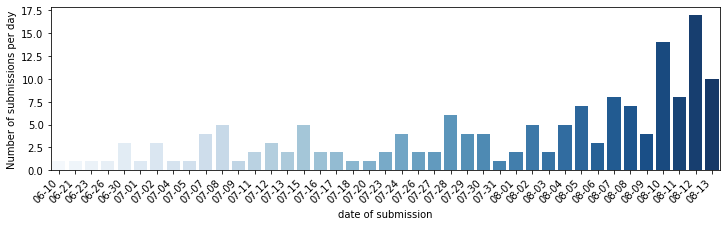

In [406]:
# Get submissions per day

## filter only submissions before deadline
filtered = df[df['timestamp'].dt.date < datetime.date(year=2021, month=8,day=14)]
days=filtered.groupby([filtered['timestamp'].dt.date]).mid.nunique().reset_index()

fig, ax = plt.subplots(figsize = (12,3), nrows=1, ncols=1)    
x_dates = filtered['timestamp'].dt.strftime('%m-%d').sort_values().unique()
fig = sns.barplot(x='timestamp', y="mid", data=days, ax=ax, palette="Blues")
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set(xlabel='date of submission', ylabel='Number of submissions per day')
plt.savefig("imgs/submissions.pdf",bbox_inches='tight')


# Analyze improvements per languages


In [392]:
def add_bar_labels(ax):
    cur_lim = ax.get_ylim()
    cur_lim = (cur_lim[0], cur_lim[1]*1.1)
    print(cur_lim)
    ax.set_ylim(cur_lim)        
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f')
        
def plot_langs(data, bycol="src", name="full"):
    longdesc={"src": "Source", "trg": "Target"}
    fig_width = {"full": 21, "small1":8, "small2": 8}
    fig, ax = plt.subplots(figsize = (fig_width[name],3), nrows=1, ncols=1)    
    sorted_data= data.groupby(bycol).perf.mean().sort_values(ascending=False)
    
    sns.barplot(data=data,x=bycol,y='perf',order=sorted_data.index, palette="crest",ci=None)
    ax.set_xticklabels(labels=sorted_data.index, rotation=90, ha='right')
    ax.set(xlabel=f'{longdesc[bycol]} language', ylabel='delta in spBLEU')
    plt.savefig(f"imgs/analysis_{name}_langs_by_{bycol}.pdf",bbox_inches='tight')
    
    
def plot_langs_families(data, bycol="src", name="full"):
    newdata= data.set_index(bycol).join(langnames.set_index('ISO 639-3')).reset_index()
    longdesc={"src": "Source", "trg": "Target"}
    newdata[bycol] = newdata["index"]
    
    fig, ax = plt.subplots(figsize = (8,3), nrows=1, ncols=1)    
    sorted_data= newdata.groupby("Subgrouping").perf.mean().sort_values(ascending=False)
    
    sns.barplot(data=newdata,x="Subgrouping",y='perf',order=sorted_data.index, palette="crest", ci=None)
    ax.set_xticklabels(labels=sorted_data.index, rotation=90, ha='right')
    ax.set(xlabel=f'{longdesc[bycol]} Language Subgroups', ylabel='delta in spBLEU')
    add_bar_labels(ax)

    plt.savefig(f"imgs/analysis_{name}_langs_by_{bycol}_subgroups.pdf",bbox_inches='tight')

    
def plot_hists_delta(data, name):
    fig, ax = plt.subplots(figsize = (5,4), nrows=1, ncols=1)   
    sns.histplot(data=data, x="perf") 
    ax.set(xlabel=f'delta in spBLEU', ylabel='frequency')
    
    plt.savefig(f"imgs/analysis_{name}_deltas_hist.pdf",bbox_inches='tight')
    

        
def analyze_task(task):
    deltas = (
    #get delta of performance between highest and baseline
    df[df.mid.isin(allp[task])].groupby(['src','trg','mid']).perf.mean().reset_index().groupby(['src','trg']).perf.max()
        - df[df.mid.isin(baselines[task])].groupby(['src','trg']).perf.mean()

    ).reset_index()
    
    deltas["max"] = df[df.mid.isin(allp[task])].groupby(['src','trg','mid']).perf.mean().reset_index().groupby(['src','trg']).perf.max().reset_index().perf
    
    ################
    print("""***Analysis of language pairs deltas***""") 
    sorted_delta = deltas.sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5] )
    print(sorted_delta[:5].to_latex(index=False) )
    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:] )
    print(sorted_delta[-5:].to_latex(index=False) )
    print(f"GAP between top and bottom by pair: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )
    
    plot_hists_delta(deltas, task)
    print('AVG improv', deltas.perf.mean())
    print('AVG improv into ENG', deltas[deltas.trg=='eng'].perf.mean())
    
    print("""***Analysis per of averages source language***""")
    sorted_delta = deltas.groupby('src').mean().sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5] )
    print(sorted_delta[:5].to_latex() )

    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:] )
    print(sorted_delta[-5:].to_latex() )
    
    print(f"GAP between top and bottom by source: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )

        
    print("""Analysis of averages per target language""")
    sorted_delta=deltas.groupby('trg').mean().sort_values(by='perf', ascending=False)
    print ("TOP 5 improvements wrt to baseline")
    print(sorted_delta[:5])
    print(sorted_delta[:5].to_latex() )
    print ("BOTTOM 5 improvements wrt to baseline")
    print(sorted_delta[-5:])
    print(sorted_delta[-5:].to_latex() )
    print(f"GAP between top and bottom by trg: {list(sorted_delta.reset_index().perf)[0] -  list(sorted_delta.reset_index().perf)[-1]}" )

    plot_langs(deltas, bycol="src", name=task )
    plot_langs_families(deltas, bycol="src", name=task )
    plot_langs(deltas, bycol="trg", name=task)
    plot_langs_families(deltas, bycol="trg", name=task )

    return deltas
    

               

## Full task analysis

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
      src  trg  perf   max
1832  eng  cym 46.41 58.37
2442  gle  eng 43.55 45.61
1841  eng  gle 43.10 43.33
5771  mlt  cym 42.88 48.49
2480  gle  mlt 41.83 43.70
\begin{tabular}{llrr}
\toprule
src & trg &  perf &   max \\
\midrule
eng & cym & 46.41 & 58.37 \\
gle & eng & 43.55 & 45.61 \\
eng & gle & 43.10 & 43.33 \\
mlt & cym & 42.88 & 48.49 \\
gle & mlt & 41.83 & 43.70 \\
\bottomrule
\end{tabular}

BOTTOM 5 improvements wrt to baseline
            src  trg  perf  max
6012        mri  luo  0.00 2.00
10143  zho_trad  kea  0.00 1.45
3851        jpn  ckb  0.00 0.14
8931        tgl  kea  0.00 3.72
5568        mar  ckb  0.00 0.15
\begin{tabular}{llrr}
\toprule
     src & trg &  perf &  max \\
\midrule
     mri & luo &  0.00 & 2.00 \\
zho\_trad & kea &  0.00 & 1.45 \\
     jpn & ckb &  0.00 & 0.14 \\
     tgl & kea &  0.00 & 3.72 \\
     mar & ckb &  0.00 & 0.15 \\
\bottomrule
\end{tabular}

GAP between top and bottom

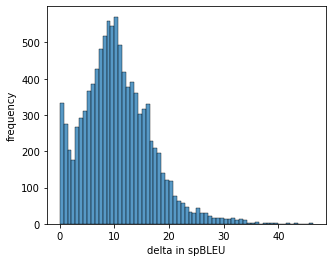

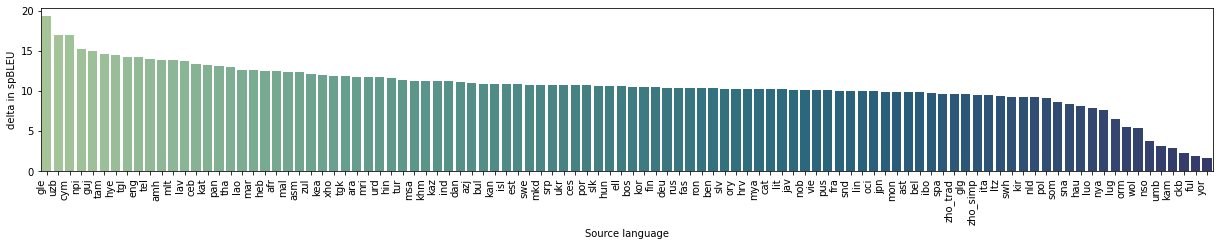

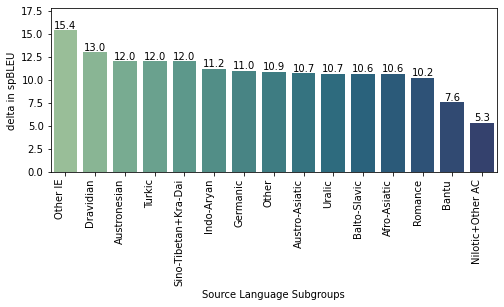

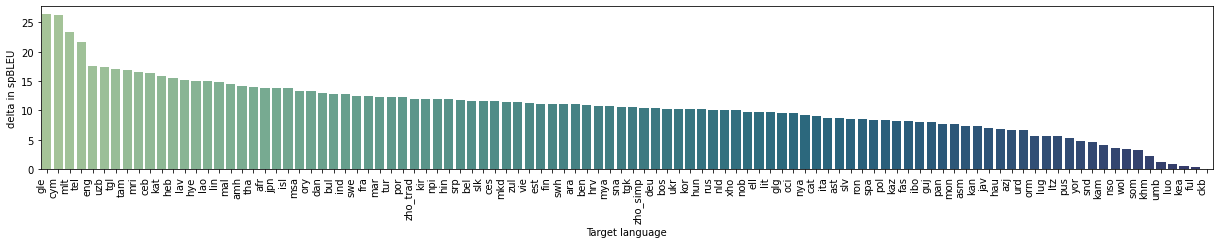

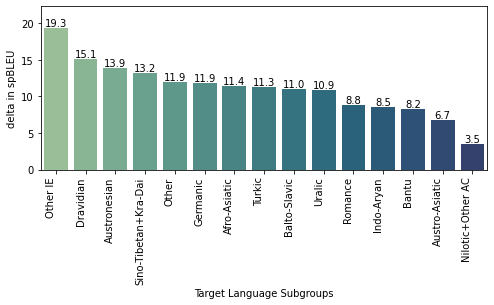

In [393]:
# full task
dd= analyze_task("full")

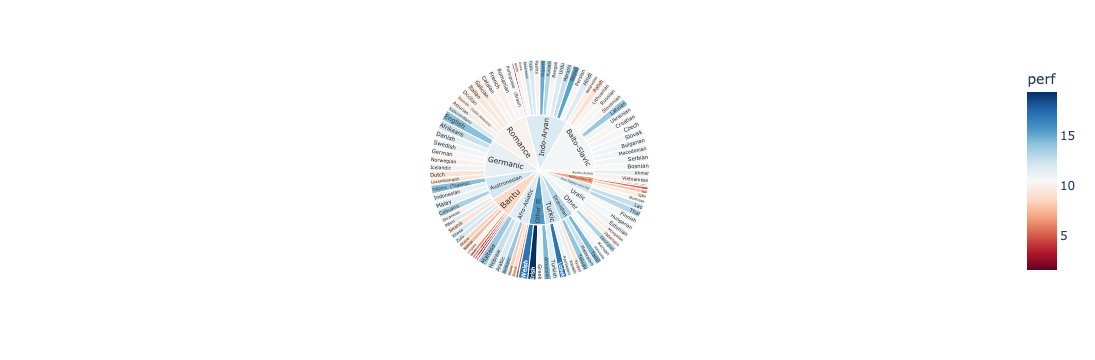

In [311]:
import plotly.express as px
newdata= dd.set_index('src').join(langnames.set_index('ISO 639-3')).reset_index()
newdata['src']=newdata["index"]

fig = px.sunburst(newdata.groupby(['Language', 'Subgrouping','Family']).mean().reset_index()
, path=['Subgrouping', 'Language'], values='max', color="perf",
color_continuous_scale='RdBu')
fig.show()

In [312]:
newdata.groupby(['Language', 'Subgrouping','Family']).mean().reset_index()


,Language,Subgrouping,Family,perf,max,Bitext w/ En,Mono Data
0,Afrikaans,Germanic,Indo-European,12.51,23.14,570000.00,26100000.00
1,Amharic,Afro-Asiatic,Afro-Asiatic,13.92,15.66,339000.00,3020000.00
2,Arabic,Afro-Asiatic,Afro-Asiatic,11.77,18.25,25200000.00,126000000.00
3,Armenian,Other IE,Indo-European,14.51,18.41,977000.00,25400000.00
4,Assamese,Indo-Aryan,Indo-European,12.32,13.19,43700.00,738000.00
...,...,...,...,...,...,...,...
95,Welsh,Other IE,Indo-European,17.01,23.21,826000.00,12700000.00
96,Wolof,Nilotic+Other AC,Atlantic-Congo,5.45,7.22,86900.00,676000.00
97,Xhosa,Bantu,Atlantic-Congo,11.93,14.84,130000.00,995000.00
98,Yoruba,Nilotic+Other AC,Atlantic-Congo,1.60,3.17,171000.00,1590000.00


# Task 1 analysis 

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
    src  trg  perf   max
4   eng  srp 19.08 46.79
25  srp  eng 15.58 49.22
20  mkd  eng 14.81 47.72
5   est  eng 14.17 43.94
15  hun  eng 13.37 42.00
\begin{tabular}{llrr}
\toprule
src & trg &  perf &   max \\
\midrule
eng & srp & 19.08 & 46.79 \\
srp & eng & 15.58 & 49.22 \\
mkd & eng & 14.81 & 47.72 \\
est & eng & 14.17 & 43.94 \\
hun & eng & 13.37 & 42.00 \\
\bottomrule
\end{tabular}

BOTTOM 5 improvements wrt to baseline
    src  trg  perf   max
17  hun  hrv  9.05 31.87
22  mkd  hrv  8.09 34.72
13  hrv  mkd  6.96 37.68
29  srp  mkd  6.49 41.40
27  srp  hrv  6.13 36.40
\begin{tabular}{llrr}
\toprule
src & trg &  perf &   max \\
\midrule
hun & hrv &  9.05 & 31.87 \\
mkd & hrv &  8.09 & 34.72 \\
hrv & mkd &  6.96 & 37.68 \\
srp & mkd &  6.49 & 41.40 \\
srp & hrv &  6.13 & 36.40 \\
\bottomrule
\end{tabular}

GAP between top and bottom by pair: 12.95
AVG improv 11.318999999999997
AVG improv into ENG 13.974
***Ana

,src,trg,perf,max
0,eng,est,12.91,38.69
1,eng,hrv,12.54,39.01
2,eng,hun,13.31,37.73
3,eng,mkd,13.15,44.52
4,eng,srp,19.08,46.79
5,est,eng,14.17,43.94
6,est,hrv,9.27,32.83
7,est,hun,10.62,32.38
8,est,mkd,10.47,36.07
9,est,srp,12.61,36.00


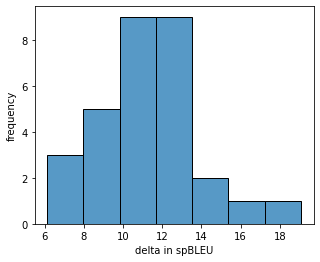

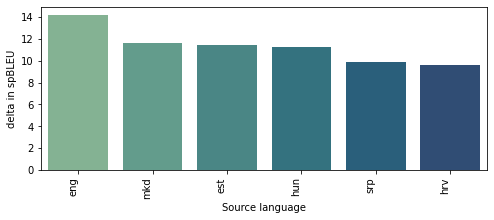

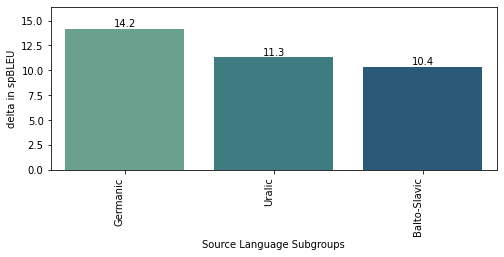

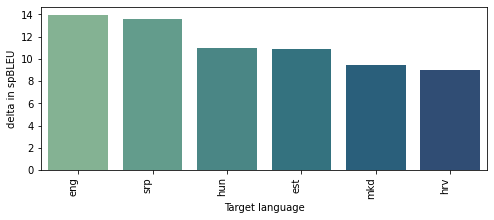

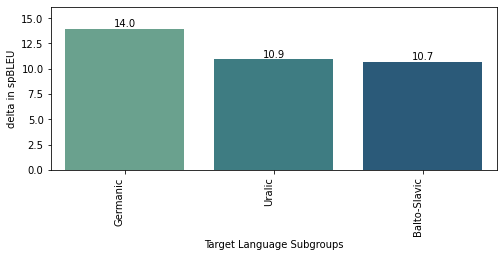

In [394]:

analyze_task("small1")

***Analysis of language pairs deltas***
TOP 5 improvements wrt to baseline
    src  trg  perf   max
3   eng  tam 31.15 34.96
20  tam  eng 30.86 35.73
25  tgl  eng 30.50 49.78
4   eng  tgl 28.45 39.05
8   ind  tam 27.97 29.02
\begin{tabular}{llrr}
\toprule
src & trg &  perf &   max \\
\midrule
eng & tam & 31.15 & 34.96 \\
tam & eng & 30.86 & 35.73 \\
tgl & eng & 30.50 & 49.78 \\
eng & tgl & 28.45 & 39.05 \\
ind & tam & 27.97 & 29.02 \\
\bottomrule
\end{tabular}

BOTTOM 5 improvements wrt to baseline
    src  trg  perf   max
27  tgl  jav 15.63 23.86
17  msa  jav 13.68 23.62
6   ind  jav 12.44 24.05
7   ind  msa 12.34 38.95
16  msa  ind 10.97 39.68
\begin{tabular}{llrr}
\toprule
src & trg &  perf &   max \\
\midrule
tgl & jav & 15.63 & 23.86 \\
msa & jav & 13.68 & 23.62 \\
ind & jav & 12.44 & 24.05 \\
ind & msa & 12.34 & 38.95 \\
msa & ind & 10.97 & 39.68 \\
\bottomrule
\end{tabular}

GAP between top and bottom by pair: 20.180000000000003
AVG improv 21.89966666666667
AVG improv into ENG 2

,src,trg,perf,max
0,eng,ind,20.41,49.23
1,eng,jav,18.99,28.42
2,eng,msa,21.60,47.92
3,eng,tam,31.15,34.96
4,eng,tgl,28.45,39.05
5,ind,eng,19.47,46.95
6,ind,jav,12.44,24.05
7,ind,msa,12.34,38.95
8,ind,tam,27.97,29.02
9,ind,tgl,24.74,32.36


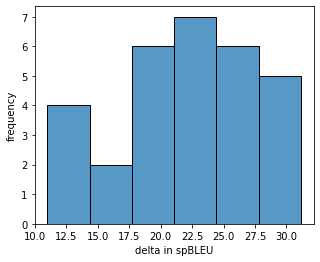

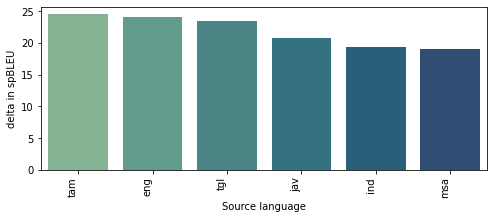

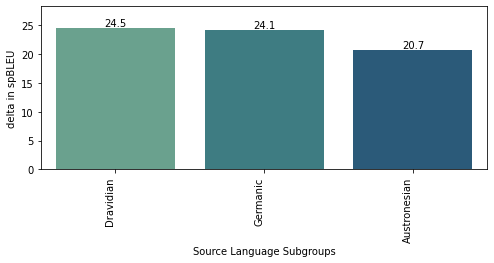

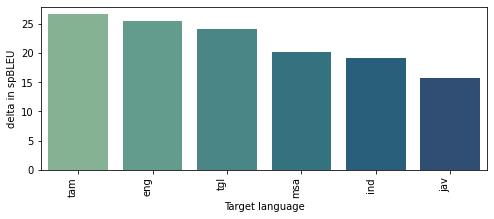

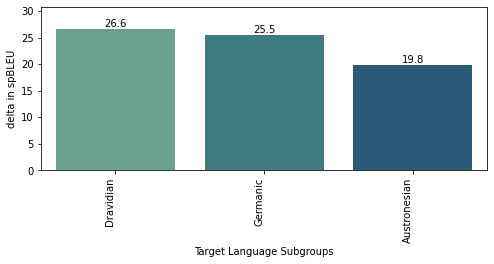

In [395]:
# task2 task
analyze_task("small2")

In [498]:

    
def contrast_mm(data, task='small1', bycol='src'):
    longdesc={"src": "Source", "trg": "Target"}
    fig_width = {"full": 21, "small1":12, "small2": 12}
    comparison=data[(data.mid.isin(winners['full']+winners[task]) ) & (data.src.isin(languages[task]) ) & (data.trg.isin(languages[task]) )]
    #sorted_data= comparison.groupby(bycol).perf.mean().sort_index(ascending=True)
    
    delta=(comparison[comparison.taskname=="full"].groupby(["src","trg"]).perf.mean() - comparison[comparison.taskname==task].groupby(["src","trg"]).perf.mean()).reset_index()

    fig, (ax1, ax2) = plt.subplots(figsize = (fig_width[task],3), nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 5]})    
    
    sns.kdeplot(data=delta,x="perf", hue=bycol, ax=ax1) 
    ax1.set(xlabel=f'delta in spBLEU by {longdesc[bycol].lower()} language', ylabel='density')
    plt.legend(title='Languages')
    
    print((comparison[comparison.taskname=="full"].groupby([bycol]).perf.mean() - comparison[comparison.taskname==task].groupby(bycol).perf.mean()).reset_index())
    print(delta.groupby(bycol).perf.mean())
    print(delta.groupby(bycol).perf.mean().reset_index().describe())

    sns.barplot(data=comparison, x=bycol, y="perf", hue="taskname", ci=None, palette="crest", ax=ax2)
    #ax.set_xticklabels(labels=sorted_data.index, rotation=90, ha='right')

    ax2.set(xlabel=f'{longdesc[bycol]} language', ylabel='Best model spBLEU')
    

    add_bar_labels(ax2)
    
    plt.legend(title='Shared Task', loc="lower right")
    plt.savefig(f"imgs/analysis_full_vs_{task}_contrast_by_{bycol}.pdf",bbox_inches='tight')

def analyze_contrast(task):
    contrast_mm(df,task, "src")
    contrast_mm(df,task, "trg")
    

No handles with labels found to put in legend.


   src  perf
0  eng -4.55
1  est -4.96
2  hrv -4.34
3  hun -4.94
4  mkd -4.86
5  srp -4.85
src
eng   -4.55
est   -4.96
hrv   -4.34
hun   -4.94
mkd   -4.86
srp   -4.85
Name: perf, dtype: float64
       perf
count  6.00
mean  -4.75
std    0.25
min   -4.96
25%   -4.92
50%   -4.86
75%   -4.62
max   -4.34
(0.0, 47.75694)


No handles with labels found to put in legend.


   trg  perf
0  eng -2.71
1  est -5.61
2  hrv -3.25
3  hun -5.43
4  mkd -4.68
5  srp -6.80
trg
eng   -2.71
est   -5.61
hrv   -3.25
hun   -5.43
mkd   -4.68
srp   -6.80
Name: perf, dtype: float64
       perf
count  6.00
mean  -4.75
std    1.54
min   -6.80
25%   -5.57
50%   -5.06
75%   -3.61
max   -2.71
(0.0, 52.15749)


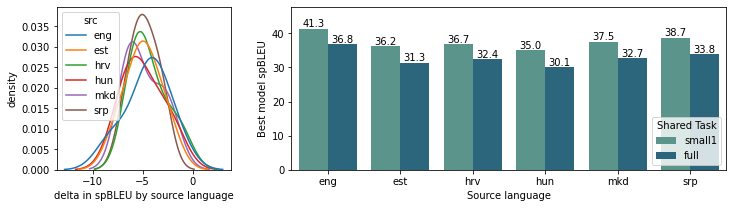

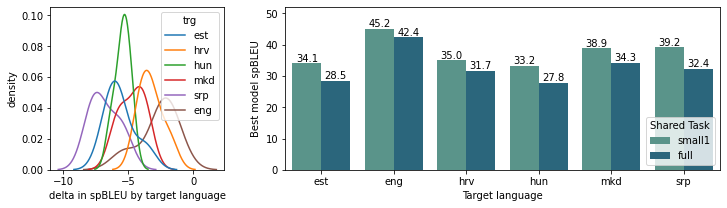

In [499]:

analyze_contrast("small1")

In [500]:
langnames[langnames["ISO 639-3"].isin(languages["small1"])]

,ISO 639-3,Language,Family,Subgrouping,Script,Bitext w/ En,Mono Data
16,hrv,Croatian,Indo-European,Balto-Slavic,Latin,42200.00,144000000.00
20,eng,English,Indo-European,Germanic,Latin,0.00,0.00
21,est,Estonian,Uralic,Uralic,Latin,4820000.00,46000000.00
35,hun,Hungarian,Uralic,Uralic,Latin,16300000.00,385000000.00
56,mkd,Macedonian,Indo-European,Balto-Slavic,Cyrillic,1130000.00,28800000.00
77,srp,Serbian,Indo-European,Balto-Slavic,Cyrillic,7010000.00,35700000.00


No handles with labels found to put in legend.


   src  perf
0  eng -4.37
1  ind -2.97
2  jav -5.97
3  msa -4.48
4  tam -3.96
5  tgl -3.78
src
eng   -4.37
ind   -2.97
jav   -5.97
msa   -4.48
tam   -3.96
tgl   -3.78
Name: perf, dtype: float64
       perf
count  6.00
mean  -4.26
std    1.00
min   -5.97
25%   -4.46
50%   -4.16
75%   -3.82
max   -2.97
(0.0, 46.10298)


No handles with labels found to put in legend.


   trg  perf
0  eng -2.04
1  ind -4.19
2  jav -7.26
3  msa -2.55
4  tam -6.72
5  tgl -2.77
trg
eng   -2.04
ind   -4.19
jav   -7.26
msa   -2.55
tam   -6.72
tgl   -2.77
Name: perf, dtype: float64
       perf
count  6.00
mean  -4.26
std    2.24
min   -7.26
25%   -6.09
50%   -3.48
75%   -2.61
max   -2.04
(0.0, 51.06486000000001)


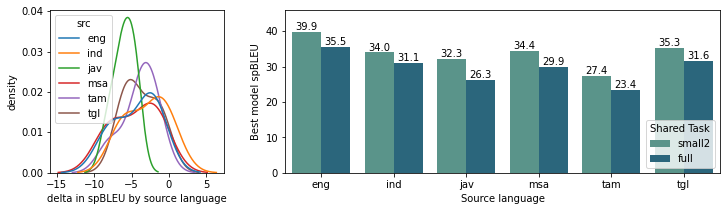

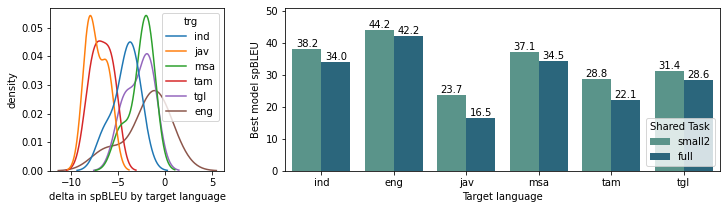

In [501]:
analyze_contrast("small2")

In [502]:
langnames[langnames["ISO 639-3"].isin(languages["small2"])]

,ISO 639-3,Language,Family,Subgrouping,Script,Bitext w/ En,Mono Data
20,eng,English,Indo-European,Germanic,Latin,0.00,0.00
22,tgl,Filipino (Tagalog),Austronesian,Austronesian,Latin,70600.00,107000000.00
38,ind,Indonesian,Austronesian,Austronesian,Latin,39100000.00,1050000000.00
42,jav,Javanese,Austronesian,Austronesian,Latin,1490000.00,24400000.00
57,msa,Malay,Austronesian,Austronesian,Latin,968000.00,77500000.00
88,tam,Tamil,Dravidian,Dravidian,Tamil,992000.00,68200000.00
